<a href="https://colab.research.google.com/github/AmriteshDOT/fraud_/blob/main/FraudDet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

df=pd.read_csv("/content/fraudTrain.csv")
# df.shape
# df=df.head(100)
df.drop(columns=['Unnamed: 0'],inplace=True)
# df.head()
df.columns
# df.info()
# df.describe()

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat',
       'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud'],
      dtype='object')

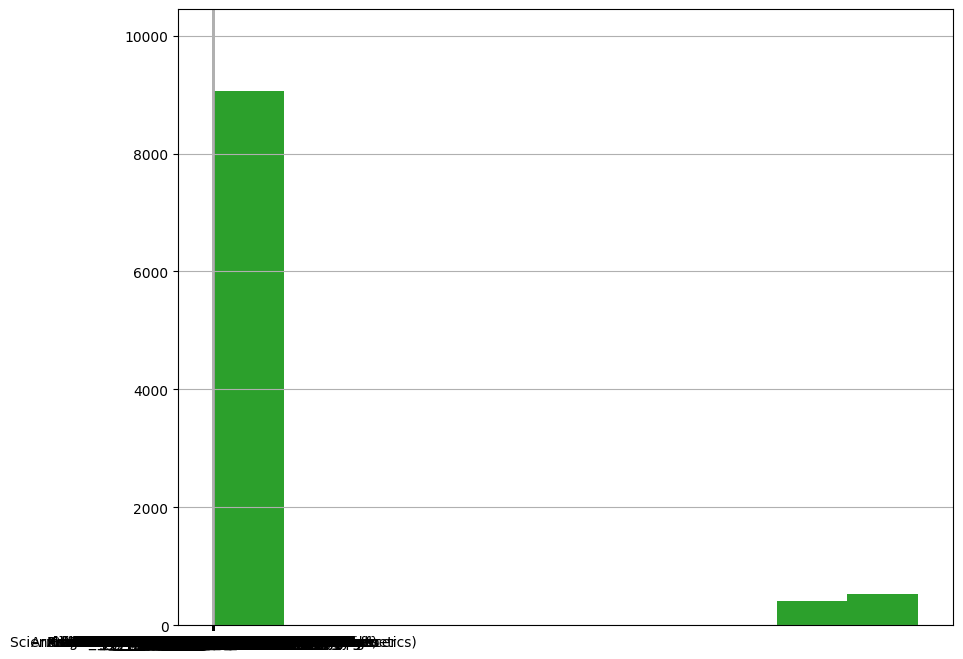

In [ ]:
tmp=pd.read_csv("/content/fraudTrain.csv")
for col in tmp.columns:
  tmp[:10000][col].hist(figsize=(10,8))


In [ ]:
# tra=pd.read_csv("/content/fraudTrain.csv")
# tst=pd.read_csv("/content/fraudTest.csv")
# tst = tst.sort_values(['trans_date_trans_time']).reset_index(drop=True)
# tra = tra.sort_values(['trans_date_trans_time']).reset_index(drop=True)


In [ ]:
# print(tra.loc[0,'trans_date_trans_time'])
# print(tra.loc[len(tra)-1,'trans_date_trans_time'])
# print(tst.loc[0,'trans_date_trans_time'])
# print(tst.loc[len(tst)-1,'trans_date_trans_time'])

In [ ]:
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['hour'] = df['trans_date_trans_time'].dt.hour
df['day'] = df['trans_date_trans_time'].dt.day
df['month'] = df['trans_date_trans_time'].dt.month
df['weekday'] = df['trans_date_trans_time'].dt.weekday
df['dob'] = pd.to_datetime(df['dob'], errors='coerce')
df['age'] = ((df['trans_date_trans_time'] - df['dob']).dt.days / 365.25).fillna(0).astype(int)
df['dob_missing'] = df['dob'].isna().astype(int)
df['amt_decimal'] = ((df['amt'] - df['amt'].astype(int)) * 100).astype(int)
pd.options.display.max_rows = 100

In [ ]:
# interactions
# print(df.columns)
# catcol=['cc_num', 'merchant', 'category',
#        'gender', 'city', 'state' ,
#         'job','hour','weekday', 'age']
# for i in range(len(catcol)):
#   for j in range(i+1,len(catcol)):
#     n1=df[catcol[i]].nunique()
#     n2=df[catcol[j]].nunique()
#     x = df[catcol[i]].astype(str) + '_' + df[catcol[j]].astype(str)
#     n3=x.nunique()
#     ratio=n3/(n1*n2)
#     if(ratio>=0.1 and ratio<=0.7):
#       print(f"{catcol[i]}_{catcol[j]} => {n3/(n1*n2)}")
df["cc_num_gender"] = df["cc_num"].astype(str) + '_' + df["gender"].astype(str)
df["gender_city"] = df["gender"].astype(str) + '_' + df["city"].astype(str)
df["gender_job"] = df["gender"].astype(str) + '_' + df["job"].astype(str)
df["state_age"] = df["state"].astype(str) + '_' + df["age"].astype(str)


In [ ]:
#entropy
from collections import Counter
import math
import pandas as pd

def norm_entropy(values):

    if(len(values)==0):
      return 0
    counts = Counter(values)
    probs = [c / len(values) for c in counts.values()]
    ent = -sum(p * math.log2(p) for p in probs)
    k = len(counts)
    if k <= 1:
        return 0
    ent_norm = ent / math.log2(k)
    return ent_norm

cat_pairs = [
    ('cc_num', 'merchant'),
    ('cc_num', 'state'),
    ('cc_num', 'category'),
    ('merchant', 'cc_num'),
    ('merchant', 'state'),
    ('state', 'merchant')
]

for a, b in cat_pairs:
    ent_col = f'ent_{a}_{b}'
    ent_map = df.groupby(a)[b].apply(norm_entropy)
    df[ent_col] = df[a].map(ent_map)



In [ ]:
df.head(5)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,cc_num_gender,gender_city,gender_job,state_age,ent_cc_num_merchant,ent_cc_num_state,ent_cc_num_category,ent_merchant_cc_num,ent_merchant_state,ent_state_merchant
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,2703186189652095_F,F_Moravian Falls,"F_Psychologist, counselling",NC_30,0.974737,0,0.969940,0.973143,0.931872,0.990963
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,630423337322_F,F_Orient,F_Special educational needs teacher,WA_40,0.973777,0,0.966666,0.970651,0.937246,0.990164
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,38859492057661_M,M_Malad City,M_Nature conservation officer,ID_56,0.980562,0,0.976680,0.971864,0.933457,0.983258
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,3534093764340240_M,M_Boulder,M_Patent attorney,MT_51,0.981409,0,0.965907,0.966620,0.937846,0.988059
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,375534208663984_M,M_Doe Hill,M_Dance movement psychotherapist,VA_32,0.974836,0,0.968673,0.970050,0.927179,0.989848


In [ ]:
df['day_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['day_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2-lat1, lon2-lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

df['distance'] = haversine(df['lat'], df['long'], df['merch_lat'], df['merch_long'])
###
for col in ['cc_num', 'merchant', 'category']:
    df[f'{col}_trans_count'] = df.groupby(col)['amt'].transform('count')
    df[f'{col}_mean_amt'] = df.groupby(col)['amt'].transform('mean')
    df[f'{col}_std_amt'] = df.groupby(col)['amt'].transform('std').fillna(0)

df['amt_to_mean_cc'] = df['amt'] / (df['cc_num_mean_amt'] + 1e-6)



In [ ]:
# interactions
df['state_gender'] = df['state'] + '_' + df['gender']
df['high_value_old'] = (df['age'] > 60) & (df['amt'] > df['amt'].median())


In [ ]:
df['mean_amt_last_3'] = df.groupby('cc_num')['amt'].rolling(3).mean().shift(1).reset_index(0,drop=True).fillna(0)
df['median_amt_last_7'] = df.groupby('cc_num')['amt'].rolling(7).median().shift(1).reset_index(0,drop=True).fillna(0)

In [ ]:

df = df.sort_values(['cc_num', 'trans_date_trans_time']).reset_index(drop=True)

df['time_since_last_txn'] = df.groupby('cc_num')['trans_date_trans_time'].diff().dt.total_seconds()

df_idx = df.set_index('trans_date_trans_time')

df_idx['txns_last_7_days'] = df_idx.groupby('cc_num')['cc_num'].rolling('7D').count().shift(1).reset_index(level=0, drop=True)
df_idx['txns_last_1d']   = df_idx.groupby('cc_num')['cc_num'].rolling('1D').count().shift(1).reset_index(level=0, drop=True)
df_idx['txns_last_1h']   = df_idx.groupby('cc_num')['cc_num'].rolling('1h').count().shift(1).reset_index(level=0, drop=True)

df['mean_amt_last_3']   = df.groupby('cc_num')['amt'].rolling(3).mean().shift(1).reset_index(0, drop=True)
df['median_amt_last_7'] = df.groupby('cc_num')['amt'].rolling(7).median().shift(1).reset_index(0, drop=True)

df_idx = df_idx.reset_index()
#velocity feats
df['txns_last_7_days'] = df_idx['txns_last_7_days'].values
df['txns_last_1d']     = df_idx['txns_last_1d'].values
df['txns_last_1h']     = df_idx['txns_last_1h'].values

df['mean_amt_last_3']   = df['mean_amt_last_3'].fillna(0)
df['median_amt_last_7'] = df['median_amt_last_7'].fillna(0)
df['txns_last_7_days']  = df['txns_last_7_days'].fillna(0)
df['txns_last_1d']      = df['txns_last_1d'].fillna(0)
df['txns_last_1h']      = df['txns_last_1h'].fillna(0)
df['time_since_last_txn'] = df['time_since_last_txn'].fillna(999999)

df['is_weekend'] = df['weekday'].isin([5,6]).astype(int)
import holidays
us_holidays = holidays.US()
df['is_holiday'] = df['trans_date_trans_time'].dt.date.apply(lambda x: int(x in us_holidays))
df['is_peak_hour'] = df['hour'].isin([8,9,10,18,19,20]).astype(int)




In [ ]:
df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,high_value_old,mean_amt_last_3,median_amt_last_7,time_since_last_txn,txns_last_7_days,txns_last_1d,txns_last_1h,is_weekend,is_holiday,is_peak_hour
0,2019-01-01 12:47:15,60416207185,"fraud_Jones, Sawayn and Romaguera",misc_net,7.27,Mary,Diaz,F,9886 Anita Drive,Fort Washakie,...,False,0.000000,0.0,999999.0,0.0,0.0,0.0,0,1,0
1,2019-01-02 08:44:57,60416207185,fraud_Berge LLC,gas_transport,52.94,Mary,Diaz,F,9886 Anita Drive,Fort Washakie,...,False,0.000000,0.0,71862.0,1.0,1.0,1.0,0,0,1
2,2019-01-02 08:47:36,60416207185,fraud_Luettgen PLC,gas_transport,82.08,Mary,Diaz,F,9886 Anita Drive,Fort Washakie,...,False,0.000000,0.0,159.0,2.0,2.0,1.0,0,0,1
3,2019-01-02 12:38:14,60416207185,fraud_Daugherty LLC,kids_pets,34.79,Mary,Diaz,F,9886 Anita Drive,Fort Washakie,...,False,47.430000,0.0,13838.0,3.0,3.0,2.0,0,0,0
4,2019-01-02 13:10:46,60416207185,fraud_Beier and Sons,home,27.18,Mary,Diaz,F,9886 Anita Drive,Fort Washakie,...,False,56.603333,0.0,1952.0,4.0,4.0,1.0,0,0,0


In [ ]:
# drop_cols = ['first', 'last', 'street', 'trans_num', 'dob', 'trans_date_trans_time']
# df.drop(columns=drop_cols, inplace=True)
pd.options.display.max_columns = 100
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 63 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   trans_date_trans_time  1296675 non-null  datetime64[ns]
 1   cc_num                 1296675 non-null  int64         
 2   merchant               1296675 non-null  object        
 3   category               1296675 non-null  object        
 4   amt                    1296675 non-null  float64       
 5   first                  1296675 non-null  object        
 6   last                   1296675 non-null  object        
 7   gender                 1296675 non-null  object        
 8   street                 1296675 non-null  object        
 9   city                   1296675 non-null  object        
 10  state                  1296675 non-null  object        
 11  zip                    1296675 non-null  int64         
 12  lat                    12966

In [ ]:
from sklearn.preprocessing import LabelEncoder
# cat_cols = df.select_dtypes('object').columns
for c in ['merchant','category','city','state','job','gender','cc_num_gender','gender_city','gender_job','state_age','state_gender']:
  le = LabelEncoder()
  df[c+'_le'] = le.fit_transform(df[c].astype(str))
#freq
for c in ['cc_num','merchant','category']:
    freq = df[c].value_counts(dropna=False)
    df[c + '_freq'] = df[c].map(freq).fillna(0)


In [ ]:
df = df.sort_values(['trans_date_trans_time']).reset_index(drop=True)
# df.info()
coldrop = df.select_dtypes(include=['object', 'string']).columns.tolist()
coldrop+=['trans_date_trans_time','dob']
df.drop(columns=coldrop, inplace=True)
# print(len(coldrop))
df = df[~df['is_fraud'].isna()].reset_index(drop=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 60 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   cc_num                1296675 non-null  int64  
 1   amt                   1296675 non-null  float64
 2   zip                   1296675 non-null  int64  
 3   lat                   1296675 non-null  float64
 4   long                  1296675 non-null  float64
 5   city_pop              1296675 non-null  int64  
 6   unix_time             1296675 non-null  int64  
 7   merch_lat             1296675 non-null  float64
 8   merch_long            1296675 non-null  float64
 9   is_fraud              1296675 non-null  int64  
 10  hour                  1296675 non-null  int32  
 11  day                   1296675 non-null  int32  
 12  month                 1296675 non-null  int32  
 13  weekday               1296675 non-null  int32  
 14  age                   1296675 non-

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import roc_auc_score

X = df.drop(columns=['is_fraud'])
y = df['is_fraud']
# X_test = X_test

folds = 3
tscv = TimeSeriesSplit(n_splits=folds)

oof_lgb = np.zeros(len(X))
oof_xgb = np.zeros(len(X))
# preds_lgb = np.zeros(len(X_test))
# preds_xgb = np.zeros(len(X_test))

#LightGBM
lgb_params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'is_unbalance': True,
    'learning_rate': 0.05,
    'num_leaves': 64,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

#XGBoost
scale_pos_weight = y.value_counts()[0] / y.value_counts()[1]
xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'aucpr',
    'tree_method': 'hist',
    'learning_rate': 0.05,
    'max_depth': 8,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'n_estimators': 20000,
    'verbosity': 0
}
for fold, (tr_idx, val_idx) in enumerate(tscv.split(X), 1):
    print(f"\nFold {fold}")

    X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]

    #LightGBM
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)

    lgb_model = lgb.train(
        lgb_params,
        lgb_train,
        num_boost_round=20000,
        valid_sets=[lgb_train, lgb_val],
        valid_names=['train', 'valid'],
        callbacks=[lgb.early_stopping(stopping_rounds=200)]
    )

    oof_lgb[val_idx] = lgb_model.predict(X_val)
    # preds_lgb += lgb_model.predict(X_test) / folds

    print("LightGBM ROC AUC:", roc_auc_score(y_val, oof_lgb[val_idx]))

    #XGBoost
    scale_pos_weight = y_tr.value_counts()[0] / y_tr.value_counts()[1]
    xgb_params['scale_pos_weight'] = scale_pos_weight

    dtrain = xgb.DMatrix(X_tr, label=y_tr)
    dval = xgb.DMatrix(X_val, label=y_val)

    evals = [(dval, 'eval')]
    bst = xgb.train(
        xgb_params,
        dtrain,
        num_boost_round=20000,
        evals=evals,
        early_stopping_rounds=100,
        verbose_eval=False
    )
    oof_xgb[val_idx] = bst.predict(dval)
    print("XG ROC AUC:", roc_auc_score(y_val, oof_xgb[val_idx]))
oof_ensemble = (oof_lgb + oof_xgb) / 2
threshold = 0.5
oof_labels = (oof_ensemble >= threshold).astype(int)
# preds_ensemble = (preds_lgb + preds_xgb) / 2

valid_idx = oof_ensemble != 0 #timeSeriesSplit
print("Overall OOF ROC AUC:", roc_auc_score(y[valid_idx], oof_ensemble[valid_idx]))

!pip install optuna


Fold 1
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1000]	train's auc: 1	valid's auc: 0.998144
LightGBM ROC AUC: 0.9981438393941641
XG ROC AUC: 0.9988083115562068

Fold 2
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[149]	train's auc: 0.999997	valid's auc: 0.998854
LightGBM ROC AUC: 0.9988536276979791
XG ROC AUC: 0.9996622890437695
Overall OOF ROC AUC: 0.9982336374641877


In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score
import joblib
import optuna
from optuna.samplers import TPESampler

X = df.drop(columns=['is_fraud'])
y = df['is_fraud']

def objective(trial):

    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'tree_method': 'auto',
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'verbosity': 0
    }

    tscv_inner = TimeSeriesSplit(n_splits=3)
    aucs = []

    for tr_idx, val_idx in tscv_inner.split(X):
        X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]

        scale_pos_weight = y_tr.value_counts()[0] / y_tr.value_counts()[1]
        param['scale_pos_weight'] = scale_pos_weight

        dtrain = xgb.DMatrix(X_tr, label=y_tr)
        dval = xgb.DMatrix(X_val, label=y_val)

        evals = [(dval, 'eval')]
        bst = xgb.train(
            param,
            dtrain,
            num_boost_round=20000,
            evals=evals,
            early_stopping_rounds=100,
            verbose_eval=False
        )

        preds = bst.predict(dval)
        aucs.append(roc_auc_score(y_val, preds))

    return np.mean(aucs)

sampler = TPESampler(n_startup_trials=5)
study = optuna.create_study(
    direction='maximize',
    sampler=sampler,
    study_name="xgb_fraud_tuning",
    storage="sqlite:///xgb_optuna.db",
    load_if_exists=True
)
study.optimize(objective, n_trials=30)

print("Best Hyperparameters:", study.best_params)

best_params = study.best_params
best_params.update({
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'tree_method': 'hist',
    'verbosity': 0
})

folds = 2
tscv_outer = TimeSeriesSplit(n_splits=folds)
oof_xgb = np.zeros(len(X))

for fold, (tr_idx, val_idx) in enumerate(tscv_outer.split(X), 1):
    print(f"\nFold {fold}")
    X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]

    scale_pos_weight = y_tr.value_counts()[0] / y_tr.value_counts()[1]
    best_params['scale_pos_weight'] = scale_pos_weight

    dtrain = xgb.DMatrix(X_tr, label=y_tr)
    dval = xgb.DMatrix(X_val, label=y_val)
    evals = [(dval, 'eval')]

    bst = xgb.train(
        best_params,
        dtrain,
        num_boost_round=20000,
        evals=evals,
        early_stopping_rounds=200,
        verbose_eval=50
    )

    bst.save_model(f"xgb_fold{fold}.pkl")

    oof_xgb[val_idx] = bst.predict(dval)
    print(f"Fold {fold} ROC-AUC: {roc_auc_score(y_val, oof_xgb[val_idx])}")

valid_idx = oof_xgb != 0
print("Overall ROC-AUC:", roc_auc_score(y[valid_idx], oof_xgb[valid_idx]))



In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score
import joblib
import optuna
from optuna.samplers import TPESampler

X = df.drop(columns=['is_fraud'])
y = df['is_fraud']

def objective_lgb(trial):
    param = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'num_leaves': trial.suggest_int('num_leaves', 16, 128),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': 1,
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 5.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 5.0),
        'verbosity': -1
    }

    tscv_inner = TimeSeriesSplit(n_splits=3)
    aucs = []

    for tr_idx, val_idx in tscv_inner.split(X):
        X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]

        param['is_unbalance'] = True
        lgb_train = lgb.Dataset(X_tr, y_tr)
        lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)

        model = lgb.train(
            param,
            lgb_train,
            num_boost_round=20000,
            valid_sets=[lgb_train, lgb_val],
            early_stopping_rounds=100,
            verbose_eval=False
        )

        preds = model.predict(X_val)
        aucs.append(roc_auc_score(y_val, preds))

    return np.mean(aucs)

sampler = TPESampler(n_startup_trials=5)
study_lgb = optuna.create_study(
    direction='maximize',
    sampler=sampler,
    study_name="lgb_fraud_tuning",
    storage="sqlite:///lgb_optuna.db",
    load_if_exists=True
)
study_lgb.optimize(objective_lgb, n_trials=30)
print("Best Hyperparameters LightGBM:", study_lgb.best_params)

best_params_lgb = study_lgb.best_params
best_params_lgb.update({
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'verbosity': -1
})

#Final 2f
folds = 2
tscv_outer = TimeSeriesSplit(n_splits=folds)
oof_lgb = np.zeros(len(X))

for fold, (tr_idx, val_idx) in enumerate(tscv_outer.split(X), 1):
    print(f"\nFold {fold}")
    X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]

    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)

    model = lgb.train(
        best_params_lgb,
        lgb_train,
        num_boost_round=20000,
        valid_sets=[lgb_train, lgb_val],
        early_stopping_rounds=200,
        verbose_eval=50
    )

    model.save_model(f"lgb_fold{fold}.txt")
    oof_lgb[val_idx] = model.predict(X_val)
    print(f"Fold {fold} ROC-AUC: {roc_auc_score(y_val, oof_lgb[val_idx])}")

valid_idx = oof_lgb != 0
print("Overall LightGBM ROC-AUC:", roc_auc_score(y[valid_idx], oof_lgb[valid_idx]))


In [ ]:
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
y_true = y[valid_idx]

accuracy = accuracy_score(y_true, oof_labels[valid_idx])
f1 = f1_score(y_true, oof_labels[valid_idx])
precision = precision_score(y_true, oof_labels[valid_idx])
recall = recall_score(y_true, oof_labels[valid_idx])
pr_auc = average_precision_score(y_true, oof_labels[valid_idx])

print("Accuracy:", accuracy)
print("F1-score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("PR-AUC:", pr_auc)
print("Report:",classification_report(y_true, oof_labels[valid_idx]))



Accuracy: 0.9993440916189484
F1-score: 0.9384565288179746
Precision: 0.9600266489007329
Recall: 0.9178343949044586
PR-AUC: 0.8815931618841373
Report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00    859740
           1       0.96      0.92      0.94      4710

    accuracy                           1.00    864450
   macro avg       0.98      0.96      0.97    864450
weighted avg       1.00      1.00      1.00    864450



/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


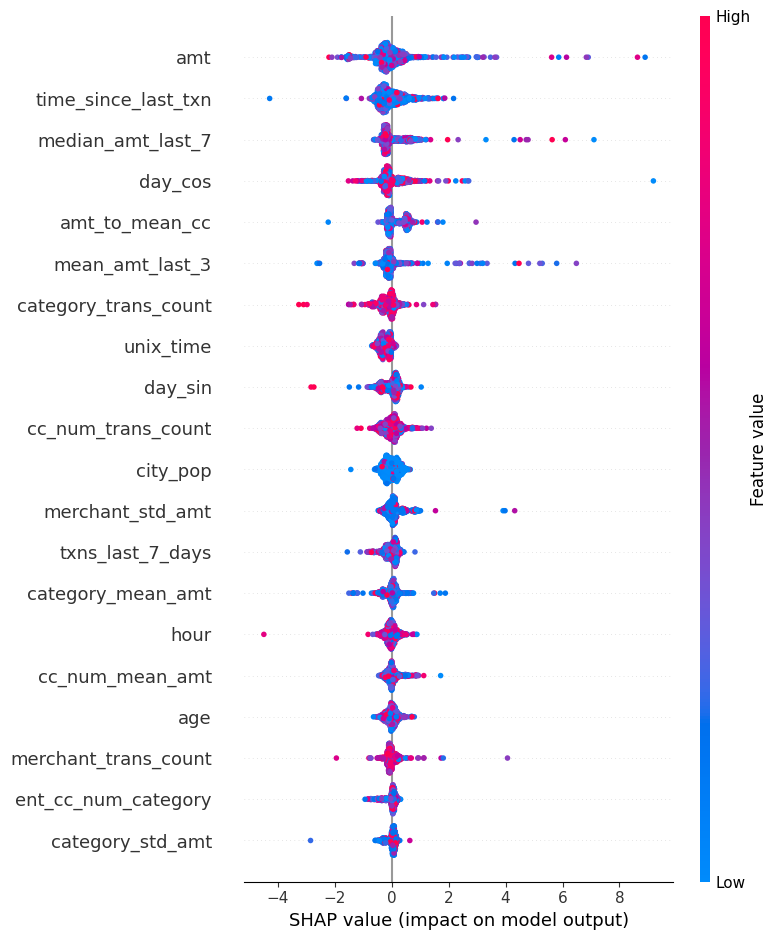

In [ ]:
import shap ,matplotlib.pyplot as plt
# import warnings
# warnings.filterwarnings('ignore')
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X[valid_idx].sample(1000))
shap.summary_plot(shap_values, X[valid_idx].sample(1000))


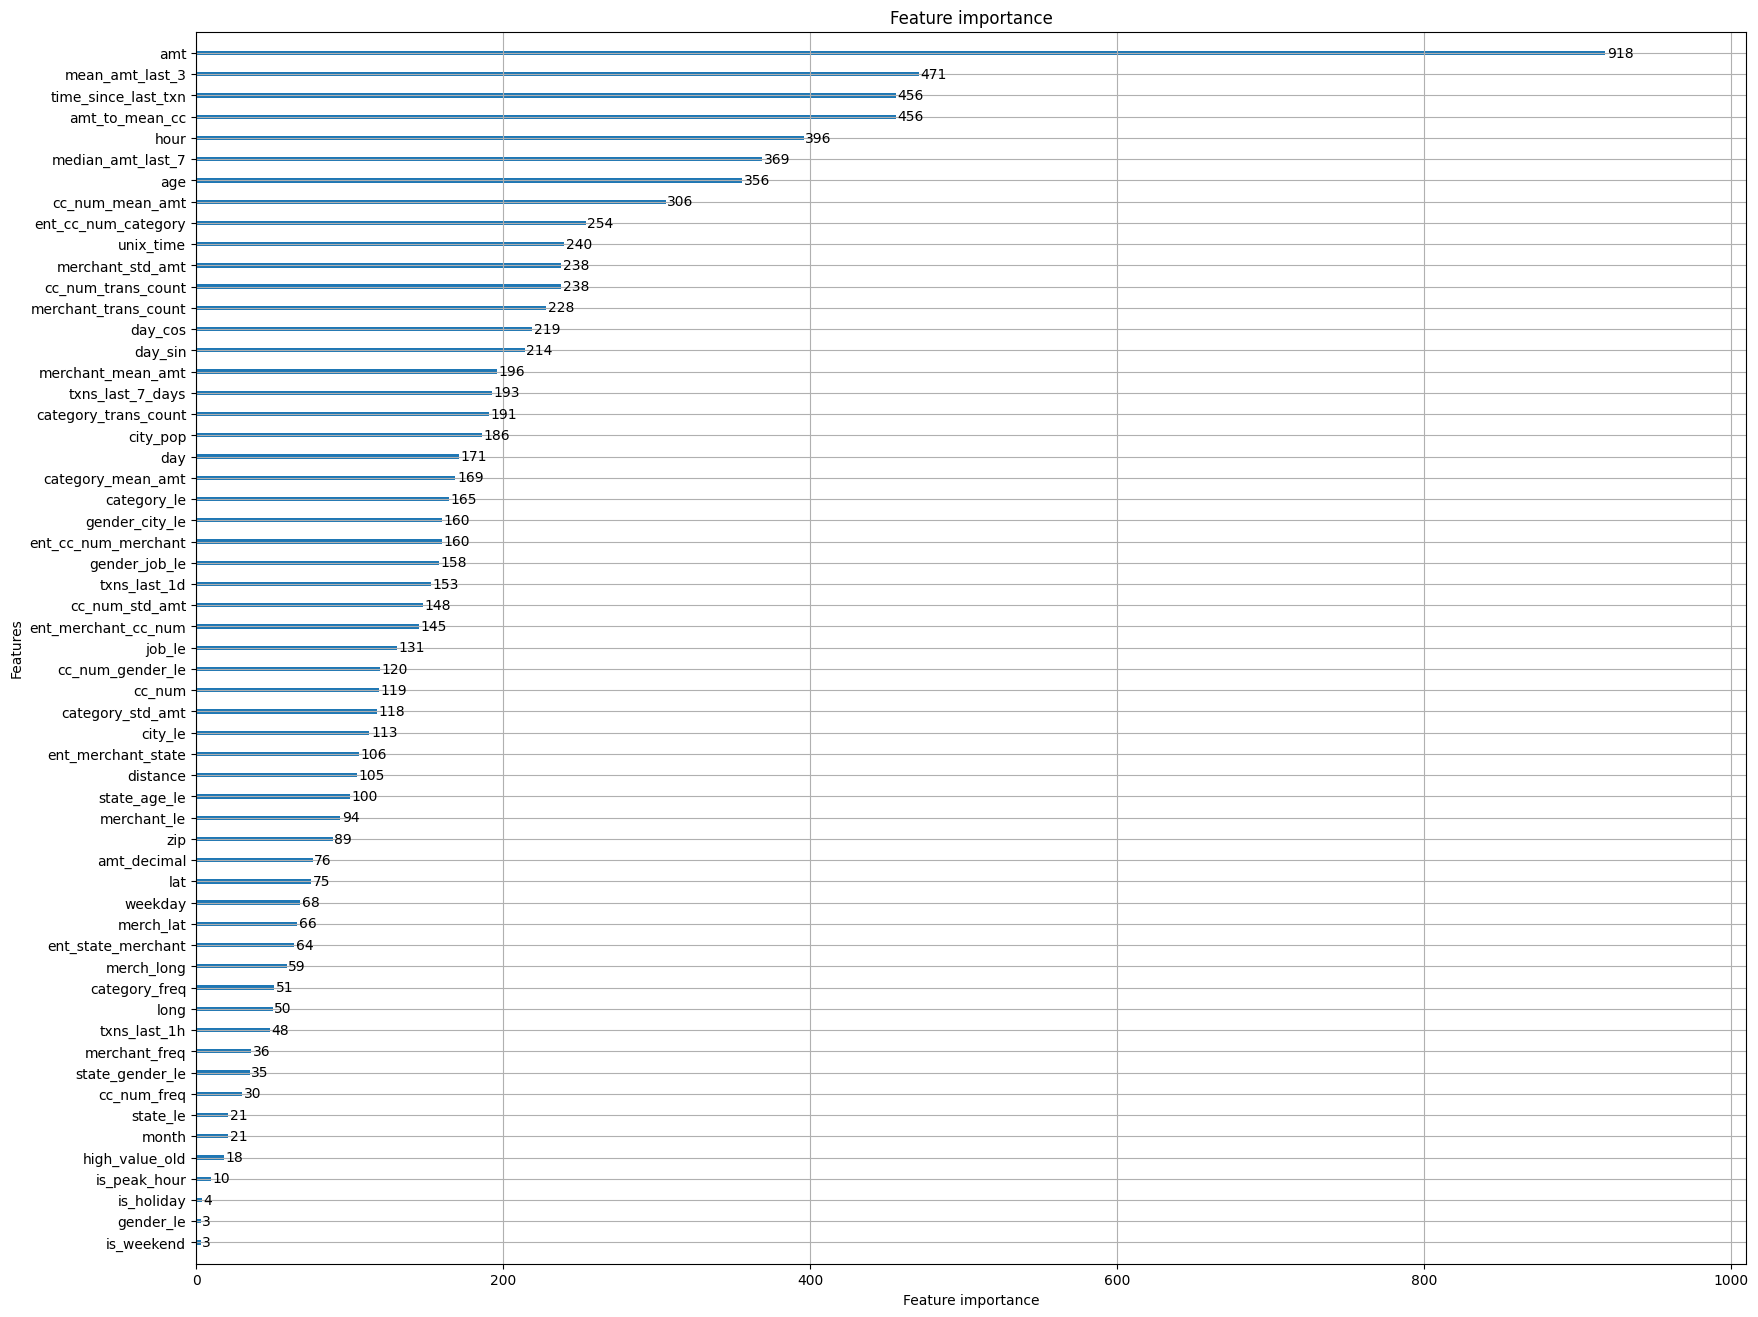

In [ ]:
lgb.plot_importance(lgb_model,figsize=(20, 16))
plt.show()
